In [1]:
# REDACT
import numpy as np
import matplotlib.pyplot as plt

# Nested Sampling - Why We Need it and How it Works
MCMC is the workhorse of Bayesian fitting in astronomy: general purpose tools like `emcee` are a near panacea for the eternal question of "how do I measure my model parameters?". However, even the best MCMC algorithm in the world has a fundamental flaw: the mission statement of sampling only near the optimum means that MCMC chains contain little to no information about the (sometimes vast) regions of parameter space at _low_ likelihood. This isn't an issue if we're trying to **marginalize** or **constrain** parameters, but leaves us completely at sea if we want to __integrate__, e.g. to get the model [information](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) or [evidence](https://en.wikipedia.org/wiki/Marginal_likelihood).

Using MCMC for evidence integrals is not just tricky, but a losing battle from the get-go: there's a fundamental mismatch between the goal of MCMC, which focuses where the likelihood is high, and integration, which can be dominated by broad low likelihood contours. There have been some attempts to use MCMC outputs for these integrals, but these have been of limited success and sometimes a source of disastrous failure. One such attempt at wrenching integrals from an MCMC chain is the infamous Harmonic Mean Estimator, a _technically_ valid but practically infamous way of estimating evidence. Enter **Nested Sampling**, a clever, robust and surprisingly simple way of getting integrals by focusing our efforts on the regions of parameter space with the highest evidence contribution.

In the first part of the article, I step through the harmonic mean estimator: showing how it's derived and then demonstrating how it can go dangerously wrong. In the second part, I walk the reader through the fundamentals of nested sampling, including building their own simple algorithm in python.

**Navigation**
* [Why We Need it: The Harmonic Mean Estimator](#sec_01)
    * [Voronoi Estimator](#sec_01_02)
    * [Where Things go Wrong](#sec_01_02)
* [How Nested Sampling Works](#sec_02)
    * [Building a Nested Sampler](#sec_02_01)
        * [A First, Bad Attempt](#sec_02_01_01)
        * [Diagnostics](#sec_02_01_02)
        * [A Second (Better) Attempt](#sec_02_01_03)
    * [MCMC Chains from Nested Sampling](#sec_02_02)
* [Some Final Notes](#sec_03) 

## Why We Need it: The Harmonic Mean Estimator <a id='sec_01'></a>

In this section we'll look at the Harmonic Mean Estimator, first introduced by [Newton & Rafferty (1994)](https://www.jstor.org/stable/2346025), including its derivation, a more geometrically-motivated explanation of what its assuming, and a demonstration of how these assumptions cause it to blow up under pretty typical conditions.

In brief, the harmonic mean estimator says that the evidence can be estimated from the harmonic mean of our sample likelihoods, i.e.:

$$
Z \approx \mathbb{E}\left[\frac{1}{\mathcal{L(\theta)}}\right]_\theta ^{-1} 
$$

Why? Well, an expected value is just the posterior-weighted integral:

$$
\mathbb{E}\left[\frac{1}{\mathcal{L}}\right]_\theta = \int{ \frac{1}{\mathcal{L(\theta)}} \times P(\theta) d\theta}
$$

And the posterior is $P(\theta) = \frac{1}{Z} \mathcal{L(\theta)}\pi(\theta)$, so:

$$
\mathbb{E}\left[\frac{1}{\mathcal{L}}\right]_\theta = \int{ \frac{1}{\mathcal{L(\theta)}} \times \frac{1}{Z} \mathcal{L(\theta)}\pi(\theta) d\theta}
$$

The $\mathcal{L(\theta)}$ terms cancel, $Z$ factorizes out as a constant, and we're left with the integral of the prior which comes to $1$:

$$
\mathbb{E}\left[\frac{1}{\mathcal{L}}\right]_\theta = \frac{1}{Z}\times\int{\pi(\theta) d\theta}=\frac{1}{Z}
$$

Easy enough: this is **consistent estimator**, its expected value is bang-on the thing we're trying to estimate as $N\rightarrow\infty$. What we'll see in a moment is that while this estimator has the correct convergence, its **variance** can be ridiculous. Rather than slog through this analytically, I'll demonstrate this visually with some nice graphics, though first we need to take a little detour into the geometry of the problem.

In [2]:
# REDACT

# Model Definitions
prior_width = 5
Nsample = 1_000
likelihood_width = 1
prior_type = "uniform"

#----------------------
if prior_type == "cauchy":
    #Cauchy Prior
    Z_true = 0.0038
    def prior(X,Y):
        out = 1/(np.pi*prior_width) * (1 + (X/prior_width)**2)**-1
        out*= 1/(np.pi*prior_width) * (1 + (Y/prior_width)**2)**-1
        return(out)
        
    def samples(Nsample):
        Xprior, Yprior = np.random.standard_cauchy(size=Nsample)*prior_width, np.random.standard_cauchy(size=Nsample)*prior_width
        return(Xprior,Yprior)

elif prior_type == "uniform":
    # Uniform Prior
    Z_true = 1/(2*prior_width)**2
    def prior(X,Y):
        out = np.ones_like(X)/(2*prior_width)**2
        out[np.where((abs(X)>prior_width)*(abs(Y)>prior_width))]*=0
        return(out)
    
    def samples(Nsample):
        Xprior, Yprior = np.random.rand(Nsample)*2-1, np.random.rand(Nsample)*2-1
        Xprior*=prior_width
        Yprior*=prior_width
        return(Xprior,Yprior)

#----------------------
# LIKELIHOOD
def LL(X,Y):
    out = np.exp( -(X**2 + Y**2) /2 / likelihood_width**2)
    out/=likelihood_width**2 * 2*np.pi
    return(out)

#--------------
# SAMPLING
Xprior, Yprior = samples(Nsample)
PI, L = prior(Xprior,Yprior), LL(Xprior,Yprior)
I = np.random.choice(np.arange(Nsample), Nsample, p = L/L.sum(), replace=True)

if False:
    plt.scatter(Xprior,Yprior, s = 1)
    plt.scatter(Xprior[I],Yprior[I], s = 1)
    plt.axis('square')
    plt.xlim(-prior_width*5, prior_width*5)
    plt.ylim(-prior_width*5, prior_width*5)
    plt.grid()
    plt.xlabel("x"), plt.ylabel("y")
    plt.title("prior_type: %s, True Evidence: %.4f" %(prior_type, Z_true))
    plt.show()

### Voronoi Estimator <a id='sec_01_01'></a>

For the sake of simplicity, lets look at a toy model so that the evidence is an area integral. Suppose we have some set of MCMC samples, $\{\theta_i\}$ distributed proportional to the posterior, and we've been smart enough to keep a track of their likelihoods and such. One way to think of the evidence is by saying that each sample is 'responsible' for some small region of parameter space, $A_i$, so that the integral can be estimated like:

$$
Z = \int{\mathcal{L}(\theta)\pi(\theta) dA} \approx \sum_i{\mathcal{L}(\theta_i)\pi(\theta_i) A_i}
$$

Any evidence integral is going to be _some_ kind of weighted sum, so this is true in general, but in our naive approach lets just say that $A_i$ is the region closest to point $i$ rather than any other point. A point in a densely packed region has a small $A_i$, a point in a sparsely sampled region has a large $A_i$. This goes by a few names: the rectangular rule, zero-th order integration, nearest neighbor interpolation. Absent a catchy name I'll call this the "Voronoi Estimator" after the [sort of diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) we estimate the areas with.

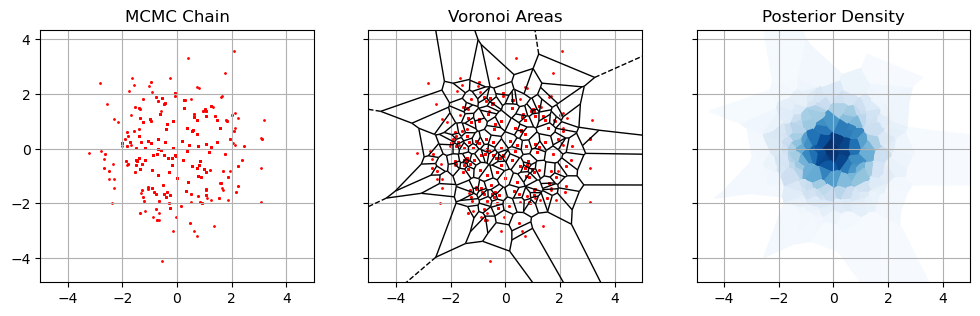

In [3]:
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.spatial import Voronoi, voronoi_plot_2d

f, (a1,a2,a3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))

V = Voronoi(np.vstack([Xprior[I], Yprior[I]]).T)

# find min/max values for normalization
C = L[I] * PI[I]
minima = min(C)
maxima = max(C)

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)

voronoi_plot_2d(V, show_vertices =False, show_points = False, ax=a2)

for r in range(len(V.point_region)):
    region = V.regions[V.point_region[r]]
    if not -1 in region:
        polygon = [V.vertices[i] for i in region]
        a3.fill(*zip(*polygon), color=mapper.to_rgba(C[r]))

for a in (a1,a2,a3):
    a.grid()
    a.set_aspect('equal')
    if a !=a3: a.scatter(Xprior[I],Yprior[I], s=1, c='r')
    a.set_xlim(-5,5)

a1.set_title("MCMC Chain")
a2.set_title("Voronoi Areas")
a3.set_title("Posterior Density")
plt.show()


This is the most direct and naive way to integrate from a chain of MCMC samples, but how does it relate to the harmonic mean? Well, consider that density of the points scales with the posterior, so the area scales **against** this probability density:

$$
A_i \propto \frac{1}{\mathcal{L}(\theta_i) \pi(\theta_i)}
$$

For some constant of proportionality $k$, the evidence estimate simplifies dramatically:

$$
Z \approx \sum_i{ \left( \mathcal{L}(\theta_i) \pi(\theta_i) \times k \frac{1}{\mathcal{L}(\theta_i) \pi(\theta_i)} \right)} = \sum_i{k} = k \cdot N
$$

Lets consider a really simple case, where the prior is uniform<sup>(1)</sup> such that $\pi(\theta) = \frac{1}{A_{total}}$. We know that all the area elements have the cover this total area:

$$
A_{total} =\sum_i{ \left( k \frac{1}{\mathcal{L}(\theta_i) \pi(\theta_i)} \right)}
$$

Which lets us estimate '$k$', and in turn $Z$ as:

$$
Z \approx \frac{A_{total} \cdot N}{\sum_i{ \left( \frac{1}{\mathcal{L}(\theta_i) \frac{1}{A_{total}}} \right)}} = \left( \frac{1}{N} \sum_i{\frac{1}{\mathcal{L}(\theta_i)}} \right) ^ {-1} = \mathbb{E}\left[\frac{1}{\mathcal{L}(\theta_i)}\right]^{-1}
$$

We've landed right back at the harmonic mean estimator! **The Voronoi estimator is equivalent to the harmonic mean estimator!**

<sup>1</sup> _Because evidence is immune to re-parameterization, and we can always map to some domain where $\pi(\theta)$ is uniform, this "special case" that we used as an example holds in general barring any weird topological edge cases._

### Where Things go Wrong <a id='sec_01_02'></a>
So we have a common-sense way to estimate an integral, and a nice easy way to calculate that estimate. We're home free, right? Unfortunately, no. While this harmonic mean trick converges to the right answer, its variance is absolutely atrocious. To see why, lets take look at our example from above,<sup>2</sup> but with a few different sample densities / MCMC chain lengths. As we get more samples, our areas get more granular and precise for the high likelihoods near the center. However, no matter how many samples we take there are always going to be enormous chunks out at the fringes that are both very large and extremely imprecise.

<sup>2</sup> _The exact case is a Cauchy distribution of width $5$ for the prior, and a Gaussian of width $1$ for the likelihood_

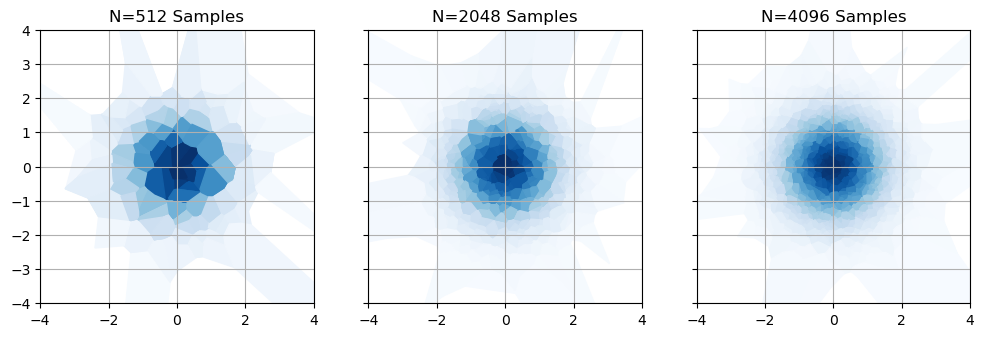

In [4]:
# REDACT

import matplotlib as mpl
import matplotlib.cm as cm
from scipy.spatial import Voronoi, voronoi_plot_2d

N1, N2, N3 = 512, 2048, 4096
lim = 4

f, (a1,a2,a3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,4))

for N, a in zip([N1,N2,N3], [a1,a2,a3]):
    Xprior, Yprior = samples(N)
    PI, L = prior(Xprior,Yprior), LL(Xprior,Yprior)
    I = np.random.choice(np.arange(N), N, p = L/L.sum(), replace=True)

    XY = np.vstack([Xprior[I],Yprior[I]])
    V = Voronoi(XY.T)

    plt.sca(a)
    
    plt.axis('square')
    plt.xlim(-lim,lim), plt.ylim(-lim,lim)

    # find min/max values for normalization
    C = L[I]*PI[I]
    minima = min(C)
    maxima = max(C)
    
    # normalize chosen colormap
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues)
    for r in range(len(V.point_region)):
        region = V.regions[V.point_region[r]]
        if not -1 in region:
            polygon = [V.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=mapper.to_rgba(C[r]))

    #a.scatter(Xprior[I],Yprior[I], s=1, c='k', alpha=0.01)

    a.set_title("N=%i Samples"% N)
    
    plt.grid()
plt.show()

What does this do to our error estimates? Nothing good. If we simulate these MCMC chains a few thousand times and see how the estimated evidence changes, we can see two major warning signs:
1. Even though the distribution _slowly_ crawls towards $Z_{True}$ as $N\rightarrow\infty$, its still heavily skewed
2. Even disregarding this bias, there's still ridiculous amounts of variance

The reason for this is simple: MCMC chains, by their nature, give us a poor picture of what's going on at the fringes of the posterior contours, and _no_ information about whats going on in the low-likelihood "flat land" beyond. That means that some significant fraction of our Voronoi "chunks" are noisy and poorly conditioned, skewing things towards over-estimating $Z$ and leaving lots of elbow room for variance. Because the HME and Voronoi estimator are equivalent, they share all of the same issues.

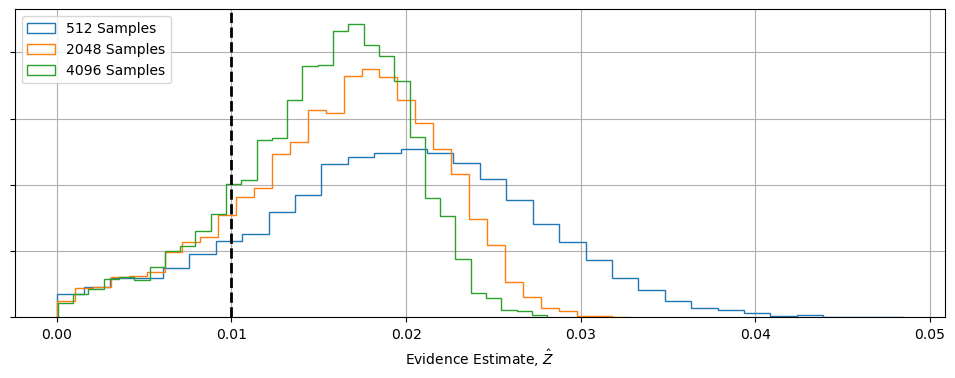

In [5]:
# REDACT
Nboot = 1024*8

Cs = ['tab:blue',
     'tab:orange',
     'tab:green',
     'tab:red']

plt.figure(figsize = (12,4))
for j,N in enumerate([N1,N2,N3]):

    Z = np.zeros(Nboot)
    for i in range(Nboot):
        #Xprior, Yprior = np.random.standard_cauchy(size=N)*prior_width, np.random.standard_cauchy(size=N)*prior_width
        Xprior, Yprior = samples(N)
        PI, L = prior(Xprior,Yprior), LL(Xprior,Yprior)
        I = np.random.choice(np.arange(N), N, p = L/L.sum(), replace=True)
        
        Z[i] = np.mean(1/L[I])**-1
        
    plt.hist(Z, bins=32, label="%i Samples" %N, density=True, histtype='step', color = Cs[j])
    #plt.axvline(Z.mean(), c = Cs[j], ls=':')

plt.grid()
plt.legend(loc='upper left')
plt.xlabel("Evidence Estimate, $\hat{Z}$")
plt.gca().set_yticklabels([])
plt.axvline(Z_true, c='k', label = 'True Evidence', lw=2, ls='--')
plt.show()

There has been some attempts to rescue the HME from these pitfalls by using importance sampling, but without these its a safe bet that HME will fail in most realistic problems. If we want to perform integrals in Bayesian Statistics, we need something better than brute force grid integration, but that covers parameter space a bit more thoroughly than MCMC.

## How Nested Sampling Works <a id='sec_02'></a>

We've seen that the harmonic mean estimator falls over in estimating evidence integrals, but this is really a limitation of MCMC itself. MCMC tells us about where the likelihood is high, but can miss the wide and shallow regions that dominate the evidence. Even if we get clever about how we interpret an MCMC chain, there's a fundamental limit to what information it gives us.

Enter [Nested Sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) (NS): the go-to method for estimating evidence integrals in Bayesian statistics. NS works by sampling the entire posterior from the outside-in, "nesting" each sample inside the contour of the previous to map the whole domain of parameter space. While MCMC can't be used to get integrals, nested sampling _can_ be used to get MCMC-like chains. For this reason, advanced NS implementations like [dynesty](https://arxiv.org/abs/1506.00171) and [PolyChord](https://arxiv.org/abs/1506.00171) see wide-spread use in astro-statistics. 

In this section, we'll explain how nested sampling works in principle, and also build a crude implementation in python to get a more physical feel for what it's doing.

The first change we have to make is a switch on how we think about integrals. The natural way to think of integration in high dimensions is to talk about the area "under" each point, e.g. in the HME example we chunked parameter space up into little columns, estimated their height and added everything together. This is an instance of a [Reimann Integral](https://en.wikipedia.org/wiki/Riemann_integral). For nested sampling, we quite literally turn things sideways for a [Lebesgue Integral](https://en.wikipedia.org/wiki/Lebesgue_integration), imagining the integral as a series of plates stacked on one another like a [Tower of Hanoi puzzle](https://en.wikipedia.org/wiki/Tower_of_Hanoi):

<html><center>
    <img src="./media/Reimann_Integral.png" alt="alt text" width="30%"/>, <img src="./media/Lesbegue_Integral.png" alt="alt text" width="30%"/>
    <br>
    <b>Sketch of Reimann Integral (Left) and Lebesgue Integral (Right)</b>
</center></html>

The nested sampling algorithm is, in brief:

1. Start by making a list of "live points", randomly but uniformly distributed across the prior
2. Sorting these in order of $f(x,y)$ so that you have $f_{Live,0} < f_{Live,1}<\dots<f_{Live,N}$
3. Randomly draw another point that has $f(x_{new},y_{new}) > f_{Live,0}$
4. Use this point to replace the old 'worst' live point, which is stored in a list of 'dead' points $\{g_i\}$, and sort this adjusted list in order
5. Continue until the live points have converged at some optimum or we hit some other common sense limit

Suppose we have $N_{Live}=100$. Because the these live points are distributed uniformly, that tells us that $\sim 99\%$ of parameter space is at a strictly higher likelihood than the worst point. If the prior has volume $V_0$, that means the area of the 'plate' containing that $99\%$ of points is $\sim 0.99 V_0$, and the Lebesgue Integral volume is $\Delta Z \approx f_{Live,0}\cdot 0.99 \cdot V_0$.

<html><center>
    <img src="./media/NestedSampling.png" alt="alt text" height="256px" width="75%"/>
    <br>
    <b>Sketch of how Nested Sampling contours shrink over each itteration</b>
</center></html>

<sup>3</sup> _Nested sampling is technically only for systems with discrete prior boundaries like this, but reparameterization or "whitening" lets us apply it to the general case as well._

When we draw a new point from _inside_ that plate, the entire process repeats. At each iteration $i$ we know that the plate "volume" is roughly $0.99^i \cdot V_0$, and its thickness is $g_{i+1}-g_i$ so that the total Lebesgue integral is something like:

$$
Z \approx \sum_i 0.99^i \cdot V_0\cdot (g_{i+1}-g_{i})
$$

Where $g_i$ is our list of dead points. This is the core idea of nested sampling: even though we don't actually know the _shape_ of the plate, we have a statistical estimate of how _large_ they are compared to the initial prior volume. You'll often see sources talking about how nested sampling collapses the multi-dimensional integral into being 1-dimensional:

$$
Z=\int V(f) df \approx \sum_i V_i \Delta f_i, \quad V_i = V_0 \lambda^i
$$

Or, alternately treating the area _between_ plates as the area elements in a Reimann-like integral:

$$
Z = \int f(V) dV \approx \sum f_i \Delta V_i, \quad \Delta V_i = V_0 (\lambda^i - \lambda^{i-1})
$$

To be a bit more rigorous, instead of shrinking by a factor $\lambda=1-\frac{1}{N_{Live}}$, the shrinkage actually obeys a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), $\lambda \sim \beta(1,N_{Live}-1)$, but this converges for large $N_{Live}$.

### Building a Nested Sampler <a id='sec_02_01'></a>
In this section, we're going to build an extremely simple nested sampling algorithm in python to see how they work, and then look at how even a few common sense changes can make them drastically more efficient than grid-based or blind Monte Carlo integration. 

First up, we'll pull in a few packages we'll need:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

Nested Sampling is a generic integration scheme, so for the sake of simplicity I'm going to skip the particulars of bayesian modelling and replace $\mathcal{L(\theta)}\cdot\pi(\theta)$ with some function $f(x,y$). We're going to look at a simple toy problem of a bimodal Gaussian in 2D. For the sake of comparison, I'm going to give this a _known_ integral of $Z_{true} = 3.0$ and a prior / integral boundaries:

$$
x\in [-5.0,5.0], \quad y \in [-2.5, 2.5]
$$

Making these in python:

In [7]:
Ztrue = 3.0

def prob_func(x,y):
    # Two gaussian modes
    out=0
    out+=np.exp(-(x - 2)**2-y**2) 
    out+=np.exp(-(x + 2)**2-y**2)

    # Normalizing
    out/=2*np.pi
    out*=Ztrue
    return(out)

In a toy case like this, integration is obviously tractable through simple brute force, but keep in mind that integration scales exponentially with dimension. In real-world problems where each evaluation can be costly, scaling like this can be a death sentence.

In [8]:
#---------------------
# Set prior boundary
xmin,xmax = -5.0, 5.0
ymin,ymax = -2.5,2.5
V0 = (xmax-xmin) * (ymax-ymin)
#---------------------
# Grid Integration
Ngrid = 128
Xgrid, Ygrid = np.meshgrid(np.linspace(xmin,xmax,Ngrid), np.linspace(ymin,ymax,Ngrid))
heatmap_grid =prob_func(Xgrid,Ygrid)
Zgrid = np.sum(heatmap_grid) / np.sum(heatmap_grid>0) * V0
print("Evidence from grid integration is %0.4f, an error of %0.2f%% with %i evaluations" %(Zgrid,abs(Zgrid/Ztrue-1)*100, Ngrid**2) )

Evidence from grid integration is 2.9522, an error of 1.59% with 16384 evaluations


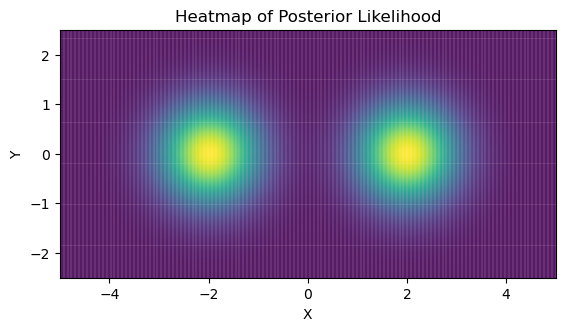

In [9]:
# REDACT
#---------------------
# Generate Heatmap
dx, dy = (xmax-xmin)/(Ngrid-1), (ymax-ymin)/(Ngrid-1)
#---------------------
# Plot heatmap
def do_heatmap(cmap = 'viridis', contrast = 1, clipping=[0,1], interpolation = 'antialiased', title="Heatmap of Posterior Likelihood"):
    fig, ax = plt.subplots(1,1)
    ax.imshow(heatmap_grid**contrast, extent=[xmin,xmax,ymin,ymax], 
              cmap = cmap, 
              vmin = heatmap_grid.max()*clipping[0], 
              vmax = heatmap_grid.max()*clipping[1], 
              interpolation = interpolation,
              zorder=-10)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    return(fig, ax)
fig, ax = do_heatmap()
for x in Xgrid[0,:]: plt.axvline(x, c='w', alpha=0.1)
for y in Ygrid[:,0]: plt.axhline(y, c='w', alpha=0.1)
plt.show()


**A First (Bad) Attempt**  <a id='sec_02_01_01'></a>  
Now onto the fun part. We're going to build an extremely simple (and initially quite inefficient) nested sampler. To build our sampler, we're going to need a way to draw new live points. As a first pass I'm going to do this with brute force prior sampling: trying points randomly until we get one that performs better than the worst live point. 

There's a rule of thumb that the number of live points should be:

$$
N_{Live}\approx 50\times N_{Modes} \times (N_{Dimensions}+1)
$$

While the maximum number of evaluations should be "a few" times $N_{Live}$. For demonstration purposes, I'm going with $N_{Live}=500$ and $N_{evals}=2,500$. We'll see in a moment that these are actually a little small, but we're starting with a crude "vibes based" sampler to map out the basic ideas before we tighten the screws.

Our algorithm needs two moving parts:
1. An initial set of live points
2. A way of generating new live points

In [10]:
Nlive = 500
Nevals = Nlive*5
#-------------------------------

np.random.seed(1)

# Draw samples uniformly from the prior
Xlive = np.random.rand(Nlive)*(xmax-xmin) + xmin
Ylive = np.random.rand(Nlive)*(ymax-ymin) + ymin
Flive = prob_func(Xlive, Ylive)

def sort_livepoints(X,Y,F):
    Isort=np.argsort(F)
    return(X[Isort], Y[Isort], F[Isort])
    
def new_live_point(X,Y,F):
    fnew = 0.0
    nevals=0
    while fnew<F.min():
        xnew = np.random.rand()*(xmax-xmin) + xmin
        ynew = np.random.rand()*(ymax-ymin) + ymin
        fnew = prob_func(xnew,ynew)
        nevals+=1
    return(xnew, ynew, fnew, nevals)

#-------------------------------
Xlive, Ylive, Flive = sort_livepoints(Xlive, Ylive, Flive)

Plotting some some sub-sample of these initial live points, we can see them scattered across the domain with, with the worst point (marked in red) sitting on a contour that encloses most of the prior volume:

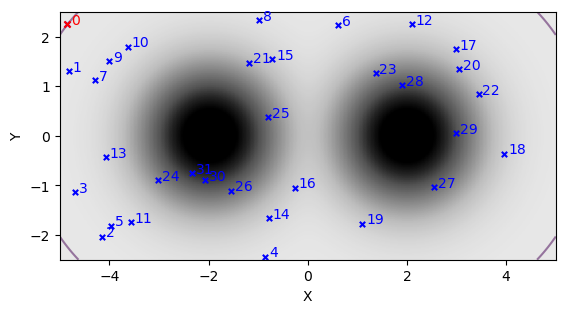

In [11]:
# REDACT
#-------------------------------------------------
fig, ax = do_heatmap('Greys', contrast = 0.5, clipping = [-0.25, 1.25], title="")
I = np.random.choice(np.arange(Nlive), 32, replace=False)
I.sort()

ax.contour(Xgrid, Ygrid, np.log(heatmap_grid), levels = [np.log(Flive[I][0].min())], cmap='viridis', zorder=-1, alpha=0.5)
ax.scatter(Xlive[I], Ylive[I],c='b', s=15, marker = 'x')
ax.scatter(Xlive[I][0], Ylive[I][0],c='r', s=20, marker = 'x')

for i in range(len(I)):
    if i in [0]:
        c = 'r' 
    else:
        c = 'b'
    ax.annotate(i, (Xlive[I][i]+dx, Ylive[I][i]), color=c)

plt.show()

Now the actual nested sampling loop. This follows a few simple steps:
1. Get the worst live point
2. Find a replacement point 
3. Save the old live point and current volume
4. Repeat (1)-(3) until we hit our maximum number of evaluations

At each iteration, our live points draw inwards towards the contour peaks, packing together exponentially tightly. I'm also going to track the number of evaluations in the array `efficiency` to see how efficient we are at finding a new live point at different times:

In [12]:
dead_points = ([],[],[])
volumes = []
efficiency = []

shrinkage = 1-1/Nlive

V = V0
i=0
while i<=Nevals:
    # Store the worst live point as a dead point
    dead_points[0].append(Xlive[0])
    dead_points[1].append(Ylive[0])
    dead_points[2].append(Flive[0])
    volumes.append(V)

    # Generate a new live point and replace the old one
    V*=shrinkage
    xnew, ynew, fnew, nevals = new_live_point(Xlive,Ylive,Flive)
    Xlive[0], Ylive[0], Flive[0] =  xnew, ynew, fnew

    efficiency.append(nevals)

    # Sort and repeat
    Xlive, Ylive, Flive = sort_livepoints(Xlive, Ylive, Flive)
    if (i%(Nevals//10))==0: print(i, end='\t')
    i+=1

print("Done")

0	250	500	750	1000	1250	1500	1750	2000	2250	2500	Done


Now we can estimate the integral. For comparison, I'm going to use both the Reimman-type and Lebesgue-type sum:

In [13]:
# Lebesgue
dZ1 = np.diff(dead_points[2]) * (np.array(volumes)[1:]+np.array(volumes)[:-1])/2
# Reimann
dZ2 = (np.array(dead_points[2][1:])+np.array(dead_points[2][:-1]))/2 * -np.diff(volumes)

Z1, Z2 = dZ1.sum(), dZ2.sum()
#----------
print("For %i Total Evaluations:" %sum(efficiency))
print("Lebesgue Integral is %.2f, an error of %.2f%%" %(Z1, abs(Z1/Ztrue-1)*100))
print("Reimann Integral is %.2f, an error of %.2f%%" %(Z2, abs(Z2/Ztrue-1)*100))

For 84891 Total Evaluations:
Lebesgue Integral is 3.00, an error of 0.01%
Reimann Integral is 2.85, an error of 5.10%


Incredible, right? Well, not really. We did barely as well as a grid-integral for significantly more evaluations. The good news is that this is down to our patchy implementation, and is not a fundamental limit of the method. In fact, our implementation has three things that make it less than ideal:
1. We discard the final live points 
2. We approximate the volume shrinkage as being constant
3. Our method of selecting new live points is hugely wasteful

**Diagnostics**  <a id='sec_02_01_02'></a>   
To see where things are going askew, we'll use a couple of the common diagnostic graph for nested sampling. We know that the total evidence integral is:

$$
Z = \sum \Delta Z_i, \quad \Delta Z_i = f_i \Delta V_i \approx \Delta f_i V_i
$$

So we can plot this how $\Delta Z$ and its sum change as the walks track inwards. For comparison, we'll also plot $f_i$ by itself, which shows how "high" the live points are as they track inwards:

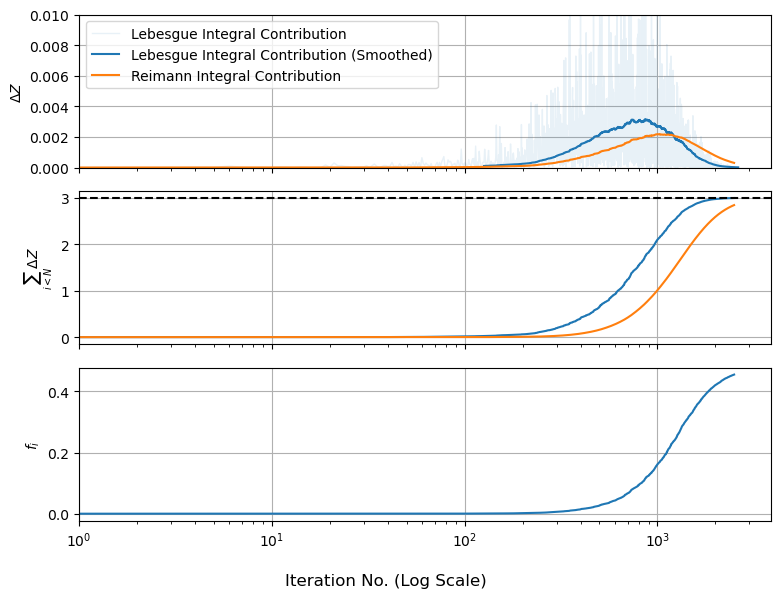

In [14]:
# REDACT
LN = np.log(np.arange(1,Nevals))
b = Nevals//10 # Smoothing Scale

dZ1_smooth = [np.sum([dZ1[min(i-j, Nevals-1)] for j in range(-b//2,b//2)])/b for i in range(Nevals-1)]


f, (a1,a2,a3) = plt.subplots(3,1,sharex=True, figsize=(8,6))

a1.plot(dZ1, label = 'Lebesgue Integral Contribution', c='tab:blue',lw=1, alpha=0.1)
a1.plot(np.exp(LN)+b//2, dZ1_smooth, label = 'Lebesgue Integral Contribution (Smoothed)')
a1.plot(dZ2, label = 'Reimann Integral Contribution')
a1.set_ylim(0,0.01)
a1.set_ylabel("$\Delta Z$")

a2.plot(np.cumsum(dZ1), label = 'Lebesgue Integral')
a2.plot(np.cumsum(dZ2), label = 'Reimann Integral')
a2.axhline(Ztrue, ls='--', c='k')
a2.set_ylabel("$\sum_{i<N}\Delta Z$")

a3.plot(dead_points[2])
a3.set_ylabel("$f_i$")

for a in [a1,a2,a3]: 
    a1.legend()
    a.grid()
    
f.supxlabel("Iteration No. (Log Scale)")
plt.xscale('log')
plt.xlim(xmin=1)
f.tight_layout()
plt.show()

We can see something interesting here: the amount of evidence at each nested shell peaks and then levels out, even though the 'height' of the function keeps going up. This is because the evidence in each shell is a product of height _and_ volume, and shells that are further out are bigger. The peak of the $\Delta Z$ bump is called the "typical set", sometimes explained as there being "only one _best_ fit, but many _okay_ fits". 

Diagnostic graphs like this are a useful sanity check on nested sampling because they tell us at a glance if / how things are breaking. We can see, for starters, that the second and third panels haven't fully leveled out and the first panel has bumps that "cut off" a bit early, suggesting that we're missing some evidence at the modal peaks. In fact, we very much are: the live points shrink inwards and leave a trail of dead points in their wake, but our current algorithm just throws the final set of live points out, meaning we miss the evidence associated with them.

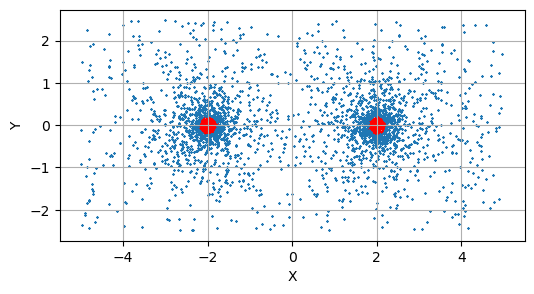

In [15]:
# REDACT

plt.figure(figsize=(6,3))
plt.scatter(Xlive, Ylive, c='r', marker='x', s=1, label = "All Dead Points")
plt.scatter(dead_points[0], dead_points[1], marker='x', s=1, label = "Final Live Points")
plt.axis('equal')
plt.xlim(xmin,xmax)

plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

For the Lebesgue integral this only "snips" the top off of the evidence, as we miss a few narrow plates. For the Reimann integral, we're basically removing the middle of our distribution like an apple core, meaning we systematically under-estimate $Z$. A brute-force way to fix this is to increase $N_{eval}$ so the missing core shrinks, but there's a less wasteful approach: each of those last live points is already nested and sorted, so we can estimate their shell sizes in the usual way and add them to our dead points.

As to the sampling method, we can plot the efficiency of our sampler and see that it drops exponentially over time. This isn't surprising: at the moment we're shooting blindly and hoping to hit an exponentially shrinking target:

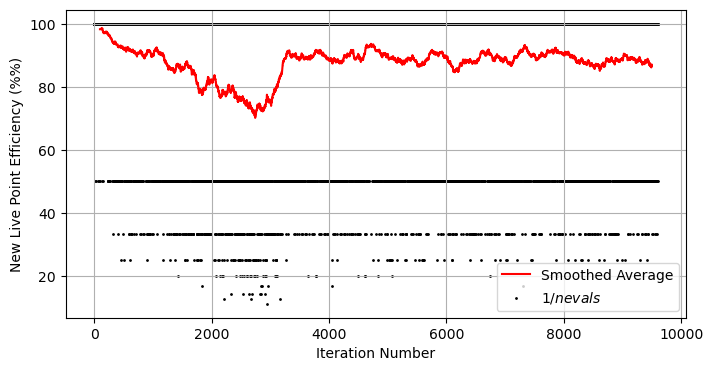

In [24]:
# REDACT
plt.figure(figsize=(8,4))
b = 200
Esmooth = np.array([np.mean(1/np.array(efficiency)[i-b//2:i+b//2]) for i in range(len(efficiency)-b//2)])

plt.plot(Esmooth*100, c='red', label = "Smoothed Average")
plt.scatter(np.arange(len(efficiency)), 1/np.array(efficiency)*100, s=1, c='k', label="1/$nevals$")

plt.xlabel("Iteration Number")
plt.ylabel("New Live Point Efficiency (%%)")
plt.grid()
plt.legend()
plt.show()

**A Second (Better) Attempt** <a id='sec_02_01_03'></a>   

So how can we improve things? Well, we can use some common sense ways to learn the shape of the distribution and narrow down or search range for new points. Below I've written a simple `new_live_point` that draws a rectangle around our live points and _only_ tests new samples within that rectangle. If the left and right sides of the distribution are separated by a wide enough margin, we break into two rectangles and continue. This is an example of targeted rejection sampling.

In [17]:
def new_live_point(X,Y,F):
    fnew = 0.0
    nevals = 0

    # Separate live points into left and right
    I_left, I_right= np.where(X<0)[0], np.where(X>0)[0]
    mu_left, width_left = X[I_left].mean(), X[I_left].ptp()
    mu_right, width_right = X[I_right].mean(), X[I_right].ptp()

    # Check if they're significantly separated
    sep = abs(mu_left-mu_right) > (width_left + width_left)
    Xmax, Xmin = X.max(), X.min()
    Ymax, Ymin = Y.max(), Y.min()
    
    while fnew<F.min():
        if sep:
            if np.random.rand()<0.5:
                xnew = (np.random.rand()*2-1)* width_left/2 + mu_left
            else:
                xnew = (np.random.rand()*2-1)* width_right/2 + mu_right
        else:
            xnew = np.random.rand()*(Xmax-Xmin) + Xmin
        ynew = np.random.rand()*(Ymax-Ymin) + Ymin
        fnew = prob_func(xnew,ynew)
        nevals+=1
    
    return(xnew, ynew, fnew, nevals)

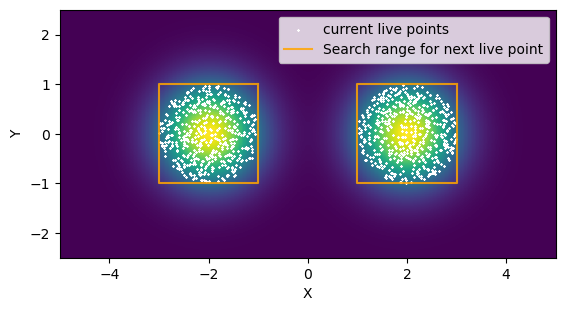

In [18]:
# REDACT
#---------------------
# Generate Heatmap
Ngrid = 128
dx, dy = (xmax-xmin)/(Ngrid-1), (ymax-ymin)/(Ngrid-1)
Xgrid, Ygrid = np.meshgrid(np.linspace(xmin,xmax,Ngrid), np.linspace(ymin,ymax,Ngrid))
heatmap_grid =prob_func(Xgrid,Ygrid)

fig, ax = do_heatmap(title=None)

Nplot = 1000
thetas = 2*np.pi * np.random.rand(Nplot)
rs = np.random.rand(Nplot)**0.5

Xplot, Yplot = rs * np.array([np.sin(thetas), np.cos(thetas)])
Xplot[:Nplot//2]+=2
Xplot[Nplot//2:]-=2
plt.scatter(Xplot, Yplot, marker='x', s=1, c='white', label = "current live points")

for dx in [-2,2]:
    plt.plot(np.array([1,1,-1,-1,1])+dx,
            [1,-1,-1,1,1],
            alpha=0.85,
            lw = 1.5,
            c= 'orange',
            label = "Search range for next live point" if dx==-2 else None)
plt.legend()
plt.show()


Equipped with this new proposal method, we can re-run with a few small changes:
1. We'll use our new method of searching for a new live point
2. Instead of $V_i = V_{i-1}\times \left(1-\frac{1}{N_{Live}}\right)$, we'll use $V_i = V_{i-1}\times \lambda, \quad \lambda \sim \beta(N_{Live}-1,1)$
3. After our main set of evaluations, we'll also use add up the evidence contributions from the final live points

We'll see in a moment that our new `new_live_point` is _much_ more efficient. I'm going to increase $N_{Live}$ and $N_{evals}$ to compensate and get a better final result:

In [19]:
Nlive = 1_600
Nevals = Nlive*6

# Draw samples uniformly from the prior
Xlive = np.random.rand(Nlive)*(xmax-xmin) + xmin
Ylive = np.random.rand(Nlive)*(ymax-ymin) + ymin
Flive = prob_func(Xlive, Ylive)
Xlive, Ylive, Flive = sort_livepoints(Xlive, Ylive, Flive)

#--------------------------------------------
dead_points = ([],[],[])
volumes = []
efficiency = []

shrinkage = 1-1/Nlive

V = V0
i=0
while i<=Nevals:
    # Store the worst live point as a dead point
    dead_points[0].append(Xlive[0])
    dead_points[1].append(Ylive[0])
    dead_points[2].append(Flive[0])
    volumes.append(V)

    # Generate a new live point and replace the old one
    V*=np.random.beta(Nlive-1,1)
    xnew, ynew, fnew, nevals = new_live_point(Xlive,Ylive,Flive)
    Xlive[0], Ylive[0], Flive[0] =  xnew, ynew, fnew

    efficiency.append(nevals)

    # Sort and repeat
    Xlive, Ylive, Flive = sort_livepoints(Xlive, Ylive, Flive)
    if (i%(Nevals//10))==0: print(i, end='\t')
    i+=1

print("Done Main Sampling")

for i in range(Nlive-1):
    V*=np.random.beta(Nlive-1-i,1)
    volumes.append(V)
    dead_points[0].append(Xlive[i])
    dead_points[1].append(Ylive[i])
    dead_points[2].append(Flive[i])

print("Done Peak Sampling")

#-------------------------
# Get Evidence Integrals

# Lebesgues
dZ1 = np.diff(dead_points[2]) * (np.array(volumes)[1:]+np.array(volumes)[:-1])/2 
#Reimann
dZ2 = (np.array(dead_points[2][1:])+np.array(dead_points[2][:-1]))/2 * -np.diff(volumes)

Z1, Z2 = dZ1.sum(), dZ2.sum()

print("For %i evaluations:" %sum(efficiency))
print("Lebesgue Integral is %.2f, an error of %.2f%%" %(Z1, abs(Z1/Ztrue-1)*100))
print("Reimann Integral is %.2f, an error of %.2f%%" %(Z2, abs(Z2/Ztrue-1)*100))

0	960	1920	2880	3840	4800	5760	6720	7680	8640	9600	Done Main Sampling
Done Peak Sampling
For 12556 evaluations:
Lebesgue Integral is 3.08, an error of 2.74%
Reimann Integral is 3.08, an error of 2.74%


We're now hitting very good precision at _less_ evaluations than a raw grid search, even with our still relatively simple sampling method. The advantages of nested sampling might not be apparent in this problem: it's low dimensional and the function we're integrating is particularly well behaved against grid integration, but the beauty of nested sampling is that it can work well in increasingly high dimensions and with unusually shaped contours.

If we plot run our diagnostic plots, we see a few things:
1. Because our sampling range shrinks along with our contours, our efficiency is pretty steady
2. Because we're not snipping off the high final likelihood points, the Lebesgue and Reimann integrals agree with one another
3. With a higher number of evaluations, we're getting a good end-result precision at low cost

The hard part of building a good nested sampler is really down to point (1): finding some clever way to sample uniformly from our "nested contours" in a way that's both robust and efficient. The trick we used here, breaking our target space into two rectangles, is a common approach. The famous `python` package [`dynesty`](https://dynesty.readthedocs.io/en/latest/dynamic.html) uses the live points to draw a series of "ellipsoids", while cosmology's own [`polychord`](https://cobaya.readthedocs.io/en/latest/sampler_polychord.html#) abandons the rejection sampling approach in favour of [slice sampling](https://en.wikipedia.org/wiki/Slice_sampling). My personal weapon of choice, [`jaxns`](https://github.com/Joshuaalbert/jaxns), uses a combination of the two.

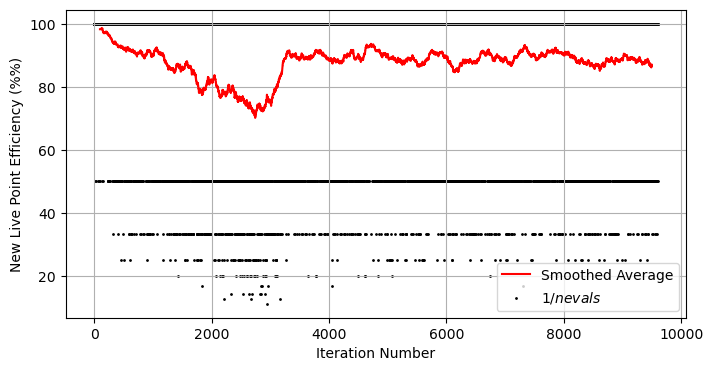

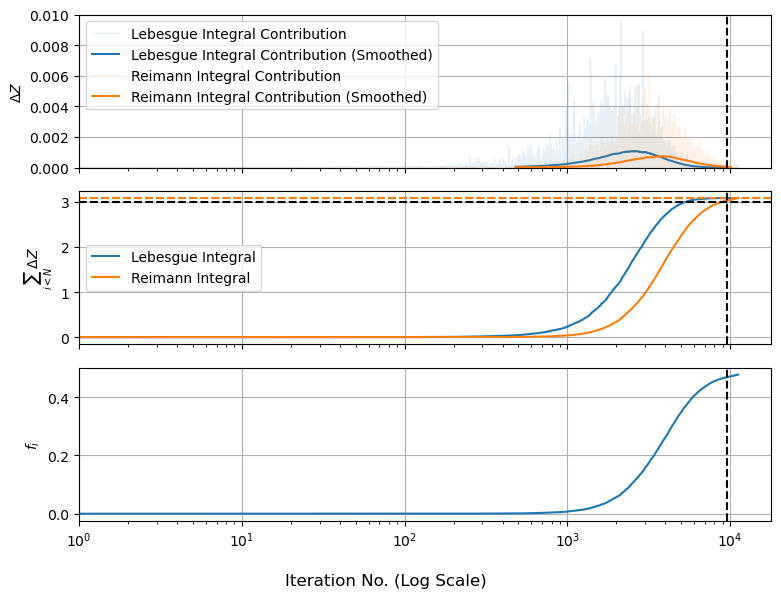

In [20]:
# REDACT
plt.figure(figsize=(8,4))
b = 200
Esmooth = np.array([np.mean(1/np.array(efficiency)[i-b//2:i+b//2]) for i in range(len(efficiency)-b//2)])

plt.plot(Esmooth*100, c='red', label = "Smoothed Average")
plt.scatter(np.arange(len(efficiency)), 1/np.array(efficiency)*100, s=1, c='k', label="1/$nevals$")

#plt.ylim(0,100)
plt.xlabel("Iteration Number")
plt.ylabel("New Live Point Efficiency (%%)")
plt.grid()
plt.legend()
plt.show()

#------------------------------

LN = np.log(np.arange(1,Nevals))
b = Nevals//10 # Smoothing Scale

dZ1_smooth = [np.sum([dZ1[min(i-j, Nevals-1)] for j in range(-b//2,b//2)])/b for i in range(Nevals-1)]
dZ2_smooth = [np.sum([dZ2[min(i-j, Nevals-1)] for j in range(-b//2,b//2)])/b for i in range(Nevals-1)]

f, (a1,a2,a3) = plt.subplots(3,1,sharex=True, figsize=(8,6))

a1.plot(dZ1, label = 'Lebesgue Integral Contribution', c='tab:blue',lw=1, alpha=0.1)
a1.plot(np.exp(LN)+b//2, dZ1_smooth, label = 'Lebesgue Integral Contribution (Smoothed)')
a1.plot(dZ2, label = 'Reimann Integral Contribution',lw=1, alpha=0.1, c = 'tab:orange')
a1.plot(np.exp(LN)+b//2, dZ2_smooth, label = 'Reimann Integral Contribution (Smoothed)')
a1.set_ylim(0,0.01)
a1.set_ylabel("$\Delta Z$")

a2.plot(np.cumsum(dZ1), label = 'Lebesgue Integral')
a2.plot(np.cumsum(dZ2), label = 'Reimann Integral')
a2.axhline(Z1, ls='--', color='tab:blue')
a2.axhline(Z2, ls='--', color='tab:orange')
a2.axhline(Ztrue, ls='--', c='k')
a2.set_ylabel("$\sum_{i<N}\Delta Z$")

a3.plot(dead_points[2])
a3.set_ylabel("$f_i$")

a1.legend(), a2.legend()
for a in [a1,a2,a3]: 
    a.axvline(Nevals,ls='--', c='k')
    a.grid()
    
f.supxlabel("Iteration No. (Log Scale)")
plt.xscale('log')
plt.xlim(xmin=1)
f.tight_layout()
plt.show()

### Getting MCMC-Like Chains from Nested Sampling <a id='sec_02_02'></a>

We've seen earlier that MCMC, a posterior estimator, is a poor tool for getting integrals. Does nested sampling, an integrator, work as a posterior estimator? Can we take our nested sampling results get an MCMC-like chain? Conveniently, yes, and really quite easily. The idea goes like this: 
1. Each sample in our dead points acts as a surrogate for an entire chunk of parameter space of volume $\Delta V_i$
2. The total "amount" of the posterior in this chunk is $\Delta Z_i = f_i \Delta V_i$
From (1) and (2), we can [importance sample](https://en.wikipedia.org/wiki/Importance_sampling), (i.e. take a weighted re-draw) of our dead-points with weights proportional to ${\Delta Z_i}$ and we'll get a list of points distributed proportional to the posterior density, i.e. an MCMC chain

In [21]:
#From earlier work, dZ2 = {f_i * dV_i}
weights = dZ2 / dZ2.sum()
I = np.random.choice(range(len(weights)), len(weights), p=weights, replace=True)
samples = {'x':np.array(dead_points[0])[1:][I],
          'y':np.array(dead_points[1])[1:][I]}

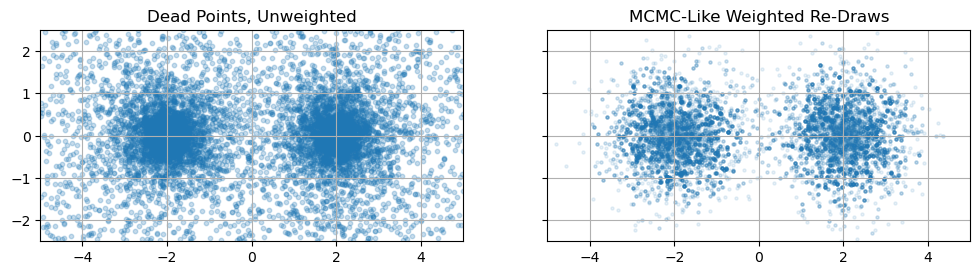

In [22]:
# REDACT
f, (a1,a2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,6))

a1.scatter(dead_points[0], dead_points[1], s=10, alpha=0.25)
a2.scatter(samples['x'], samples['y'], s=5, alpha=0.1)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

a1.set_title("Dead Points, Unweighted")
a2.set_title("MCMC-Like Weighted Re-Draws")

for a in a1,a2:
    a.set_aspect('equal')
    a.grid()

If we throw this into `ChainConsumer`, we sadly get some pretty choppy looking contours. This is a fundamental limit: Nested Sampling only takes so many samples, and we've effectively thrown most of them out. In this specific example even through we have $11,200$ samples from nested sampling, we only have $\sim 471$ "effective points" after taking the weighted re-draws.

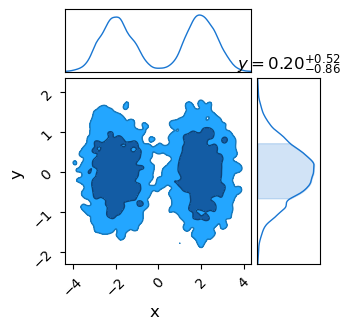

In [23]:
# ChainConsumer Plot
C = ChainConsumer()
C.add_chain(samples)
C.plotter.plot()
plt.show()

If you're dead-set on using nested sampling, the cure to this is to use more live points to slow down the progression of the sampler and force it to take more high-likelihood samples. This is a bite brutish, and a more principled approach is to use NS for a first scouting of the mode shapes before refining with MCMC.

### Some Final Notes <a id='sec_03'></a>
In this example, I've built what is still a relatively rudimentary nested sampler. Aside from their clever ways of hunting for new live points, more developed samplers have a host of other more advanced features. Most keep track of the uncertainty in the shell volumes to give constraints on $Z$ instead of a single value, and dynamic samplers like `dynesty` allow $N_{Live}$ to vary across the run to increase the sample density near the typical set, focusing evaluations where the integral is most sensitive. We've also used a pretty rough halting condition: it's common practice to simply see when $\Delta Z$ gets small and halt when the integral has converged.

Nested samplers can be at first a bit impenetrable, particularly the bespoke details of how each sampler handles the gritty process of generating proposals. In truth, the only truly difficult concept is the initial slight of hand involved in viewing the Lebesgue integral areas as shrunken fractions of the initial prior volume. With this "trick" under our belt, the rest of the principles follow mostly from geometry, even if they can be bit difficult to digest.

Fortunately, or perhaps dangerously, pre-built packages mean the end-user can usually throw nested sampling at any sort of problem without any real understanding of how it operates and almost always get a reliable answer. The value in understanding these algorithms, whether you're involved in statistical methods or just an end-user data scientist, is in understanding how and when they _don't_ work.